In [133]:
# Import General Libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [134]:
# Import Dataset
df_raw = pd.read_csv("Procurement KPI Analysis Dataset.csv")
df = df_raw.copy()

#### Data Cleaning

In [136]:
# --- 1. Standardized Column Names ---
df.columns = df.columns.str.lower().str.replace(' ', '_', regex=False)
print("--- Standardized Column Names ---")
print(df.columns.tolist())

# --- 2. Handle Data Types ---
# Convert date columns to datetime
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['delivery_date'] = pd.to_datetime(df['delivery_date'], errors='coerce')
print("\nConverted date columns to datetime.")

# Verify date conversion
print(df[['order_date', 'delivery_date']].dtypes)

# --- 3. Handle Missing Values ---
# Fill missing Defective_Units with 0 (assuming NaN means no defects reported)
df['defective_units'].fillna(0, inplace=True)
print(f"\nFilled missing 'defective_units' with 0. Remaining NaNs: {df['defective_units'].isnull().sum()}")

# Handle missing Negotiated_Price. Strategy: Impute with the Unit_Price for that row (assuming no negotiation occurred or wasn't recorded).
missing_negotiated_idx = df[df['negotiated_price'].isnull()].index
if not missing_negotiated_idx.empty:
    print(f"\nFound {len(missing_negotiated_idx)} missing 'negotiated_price'. Imputing with 'unit_price'.")
    df.loc[missing_negotiated_idx, 'negotiated_price'] = df.loc[missing_negotiated_idx, 'unit_price']
print(f"Remaining NaNs in 'negotiated_price': {df['negotiated_price'].isnull().sum()}")

# Delivery_Date NaNs will be handled during feature engineering (lead time calculation).

# --- 4. Verify Data Integrity (Optional Checks) ---
# Check if negotiated price is ever higher than unit price (shouldn't happen)
price_errors = df[df['negotiated_price'] > df['unit_price']].shape[0]
if price_errors > 0:
    print(f"\nWarning: Found {price_errors} rows where negotiated_price > unit_price.")
else:
    print("\nData Integrity Check: No rows found where negotiated_price > unit_price.")

# Check for negative quantities or prices
negative_values = df[(df['quantity'] < 0) | (df['unit_price'] < 0) | (df['negotiated_price'] < 0) | (df['defective_units'] < 0)].shape[0]
if negative_values > 0:
    print(f"\nWarning: Found {negative_values} rows with negative quantity/price/defects.")
else:
    print("Data Integrity Check: No negative values found in quantity, prices, or defects.")



--- Standardized Column Names ---
['po_id', 'supplier', 'order_date', 'delivery_date', 'item_category', 'order_status', 'quantity', 'unit_price', 'negotiated_price', 'defective_units', 'compliance']

Converted date columns to datetime.
order_date       datetime64[ns]
delivery_date    datetime64[ns]
dtype: object

Filled missing 'defective_units' with 0. Remaining NaNs: 0
Remaining NaNs in 'negotiated_price': 0

Data Integrity Check: No rows found where negotiated_price > unit_price.
Data Integrity Check: No negative values found in quantity, prices, or defects.


In [137]:
# --- 1. Calculate Lead Time ---
# Difference between delivery and order date in days
# NaT (Not a Time) will result if delivery_date is NaN
df['lead_time_days'] = (df['delivery_date'] - df['order_date']).dt.days
print("\n--- Lead Time Calculation ---")
print(f"Lead time calculated. Min: {df['lead_time_days'].min()}, Max: {df['lead_time_days'].max()}, Mean: {df['lead_time_days'].mean():.2f}")
print(f"Number of POs with missing lead time (due to missing delivery_date): {df['lead_time_days'].isnull().sum()}")

# --- 2. Calculate Costs and Savings ---
df['total_value_unit'] = df['quantity'] * df['unit_price']
df['total_value_negotiated'] = df['quantity'] * df['negotiated_price']
df['cost_savings'] = df['total_value_unit'] - df['total_value_negotiated']

# Calculate Savings Percentage (handle potential division by zero if unit_price is 0)
df['cost_savings_perc'] = np.where(
    df['unit_price'] > 0,
    ((df['unit_price'] - df['negotiated_price']) / df['unit_price']) * 100,
    0  # Assign 0% savings if unit price is 0 or less
)
# Ensure savings aren't negative due to potential data errors handled earlier
df['cost_savings'] = df['cost_savings'].clip(lower=0)
df['cost_savings_perc'] = df['cost_savings_perc'].clip(lower=0)

print("\n--- Cost & Savings Calculation ---")
print(f"Total Cost Savings across all POs: ${df['cost_savings'].sum():,.2f}")
print(f"Average Cost Savings Percentage: {df['cost_savings_perc'].mean():.2f}%")

# --- 3. Calculate Defect Rate ---
# Percentage of defective units relative to quantity ordered
# Handle potential division by zero if quantity is 0
df['defect_rate_perc'] = np.where(
    df['quantity'] > 0,
    (df['defective_units'] / df['quantity']) * 100,
    0 # Assign 0% defect rate if quantity is 0
)
print("\n--- Defect Rate Calculation ---")
print(f"Average Defect Rate: {df['defect_rate_perc'].mean():.2f}%")
print(f"Max Defect Rate: {df['defect_rate_perc'].max():.2f}%")

# --- 4. Extract Time Features ---
df['order_year'] = df['order_date'].dt.year
df['order_month'] = df['order_date'].dt.month
df['order_quarter'] = df['order_date'].dt.to_period('Q') # Quarter object
df['order_year_month'] = df['order_date'].dt.to_period('M') # Year-Month object

print("\nExtracted Year, Month, Quarter from Order Date.")

# --- 5. Define On-Time Delivery Status (Example Heuristic) ---
# This requires a definition of 'on-time'. Let's use a threshold based on typical lead times,
# or analyze lead times by category/supplier first.
# For now, let's create a flag for whether delivery occurred *at all* based on non-NaN delivery_date
df['delivery_occurred'] = df['delivery_date'].notna()

# We can also analyze lead times relative to a benchmark later in EDA.
# Example: Calculate median lead time per item category
# median_lead_times = df.groupby('item_category')['lead_time_days'].median()
# df['median_lead_time_category'] = df['item_category'].map(median_lead_times)
# df['is_late'] = df['lead_time_days'] > df['median_lead_time_category']

print("\nCreated 'delivery_occurred' flag.")


--- Lead Time Calculation ---
Lead time calculated. Min: -5.0, Max: 20.0, Mean: 10.78
Number of POs with missing lead time (due to missing delivery_date): 87

--- Cost & Savings Calculation ---
Total Cost Savings across all POs: $3,931,126.47
Average Cost Savings Percentage: 7.97%

--- Defect Rate Calculation ---
Average Defect Rate: 5.78%
Max Defect Rate: 35.71%

Extracted Year, Month, Quarter from Order Date.

Created 'delivery_occurred' flag.


In [139]:
# Display dataframe with new features
print("\n--- DataFrame with Engineered Features (Sample) ---")
df.head()


--- DataFrame with Engineered Features (Sample) ---


,po_id,supplier,order_date,delivery_date,item_category,order_status,quantity,unit_price,negotiated_price,defective_units,...,total_value_unit,total_value_negotiated,cost_savings,cost_savings_perc,defect_rate_perc,order_year,order_month,order_quarter,order_year_month,delivery_occurred
0,PO-00001,Alpha_Inc,2023-10-17,2023-10-25,Office Supplies,Cancelled,1176,20.13,17.81,0.0,...,23672.88,20944.56,2728.32,11.525087,0.000000,2023,10,2023Q4,2023-10,True
1,PO-00002,Delta_Logistics,2022-04-25,2022-05-05,Office Supplies,Delivered,1509,39.32,37.34,235.0,...,59333.88,56346.06,2987.82,5.035605,15.573227,2022,4,2022Q2,2022-04,True
2,PO-00003,Gamma_Co,2022-01-26,2022-02-15,MRO,Delivered,910,95.51,92.26,41.0,...,86914.10,83956.60,2957.50,3.402785,4.505495,2022,1,2022Q1,2022-01,True
3,PO-00004,Beta_Supplies,2022-10-09,2022-10-28,Packaging,Delivered,1344,99.85,95.52,112.0,...,134198.40,128378.88,5819.52,4.336505,8.333333,2022,10,2022Q4,2022-10,True
4,PO-00005,Delta_Logistics,2022-09-08,2022-09-20,Raw Materials,Delivered,1180,64.07,60.53,171.0,...,75602.60,71425.40,4177.20,5.525207,14.491525,2022,9,2022Q3,2022-09,True


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   po_id             777 non-null    object        
 1   supplier          777 non-null    object        
 2   order_date        777 non-null    datetime64[ns]
 3   delivery_date     690 non-null    datetime64[ns]
 4   item_category     777 non-null    object        
 5   order_status      777 non-null    object        
 6   quantity          777 non-null    int64         
 7   unit_price        777 non-null    float64       
 8   negotiated_price  777 non-null    float64       
 9   defective_units   777 non-null    float64       
 10  compliance        777 non-null    object        
dtypes: datetime64[ns](2), float64(3), int64(1), object(5)
memory usage: 66.9+ KB


In [129]:
df.describe()

,order_date,delivery_date,quantity,unit_price,negotiated_price,defective_units
count,777,690,777.000000,777.000000,777.000000,777.000000
mean,2022-12-28 23:15:31.274131456,2023-01-12 03:16:10.434782720,1094.660232,58.283822,53.660721,61.710425
min,2022-01-01 00:00:00,2022-01-06 00:00:00,51.000000,10.840000,9.270000,0.000000
25%,2022-07-02 00:00:00,2022-07-19 18:00:00,615.000000,33.290000,30.460000,11.000000
50%,2022-12-24 00:00:00,2023-01-19 12:00:00,1075.000000,58.950000,53.800000,38.000000
75%,2023-07-07 00:00:00,2023-07-18 00:00:00,1548.000000,83.130000,76.550000,85.000000
max,2024-01-01 00:00:00,2024-01-12 00:00:00,5000.000000,109.170000,107.390000,321.000000
std,NaN,NaN,647.844551,28.101315,26.094930,68.971194


In [140]:
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTENC

# ---- 1. Separate features / target ----------------------------------
features_for_model = [
    'supplier', 'item_category', 'quantity', 'unit_price', 'negotiated_price',
    'order_year', 'order_month', 'compliance'
]
target_for_model = 'delivery_occurred'

cat_cols = ['supplier', 'item_category', 'compliance']
num_cols = [c for c in features_for_model if c not in cat_cols]

X = df[features_for_model].copy()
y = df[target_for_model]

# ---- 2. Encode categorical columns as integers ----------------------
oe = OrdinalEncoder()
X_cat_enc = oe.fit_transform(X[cat_cols])          # shape (n_samples, 3)
X_num     = X[num_cols].values                     # shape (n_samples, 5)

X_enc = np.hstack([X_cat_enc, X_num])              # combined matrix
cat_indices = list(range(len(cat_cols)))           # [0, 1, 2]

# ---- 3. SMOTENC oversampling ----------------------------------------
smote = SMOTENC(categorical_features=cat_indices,
                random_state=42,
                sampling_strategy='auto')          # balance the classes

X_res, y_res = smote.fit_resample(X_enc, y)        # synthetic data added

# ---- 4. Decode encoded categoricals back to original strings --------
X_cat_dec = oe.inverse_transform(X_res[:, :len(cat_cols)])
X_num_res = X_res[:, len(cat_cols):]

# ---- 5. Build the balanced DataFrame --------------------------------
df_balanced = pd.DataFrame(X_cat_dec, columns=cat_cols)
for i, col in enumerate(num_cols):
    df_balanced[col] = X_num_res[:, i]
df_balanced[target_for_model] = y_res.values

# df_balanced is now the oversampled dataset
print(df[target_for_model].value_counts(), "\n--- before")
print(df_balanced[target_for_model].value_counts(), "--- after")

delivery_occurred
True     690
False     87
Name: count, dtype: int64 
--- before
delivery_occurred
True     690
False    690
Name: count, dtype: int64 --- after


In [141]:
# Check null values
df.isnull().sum()

po_id                      0
supplier                   0
order_date                 0
delivery_date             87
item_category              0
order_status               0
quantity                   0
unit_price                 0
negotiated_price           0
defective_units            0
compliance                 0
lead_time_days            87
total_value_unit           0
total_value_negotiated     0
cost_savings               0
cost_savings_perc          0
defect_rate_perc           0
order_year                 0
order_month                0
order_quarter              0
order_year_month           0
delivery_occurred          0
dtype: int64

In [142]:
# Check duplicated rows
df.duplicated().sum()

0

#### Exploratory Data Analysis

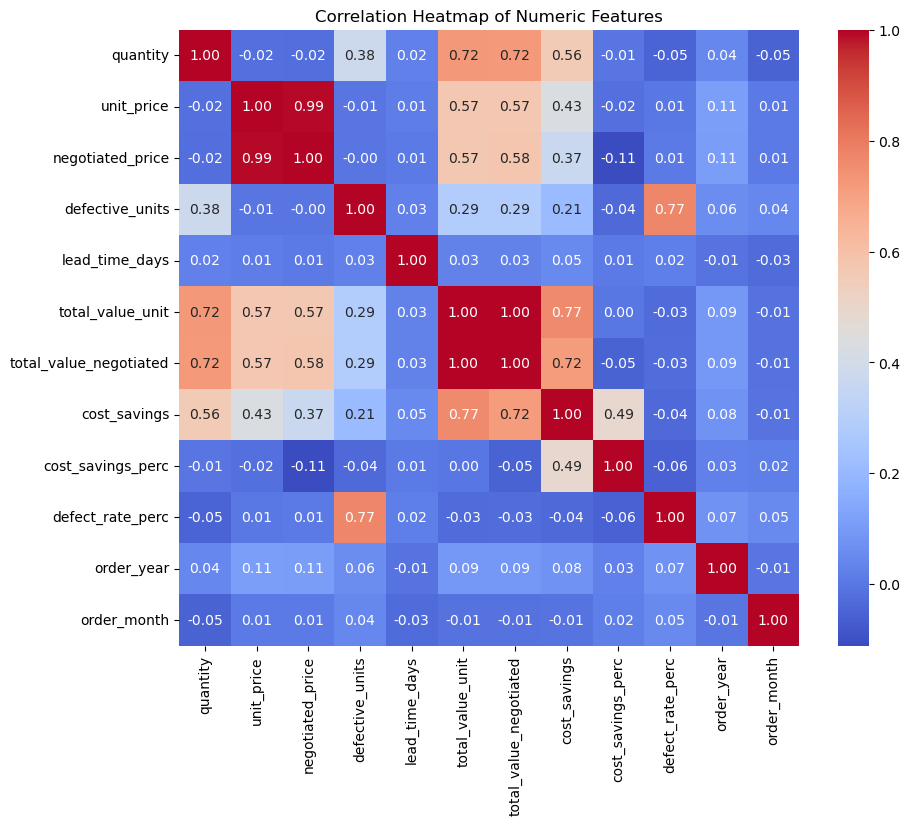

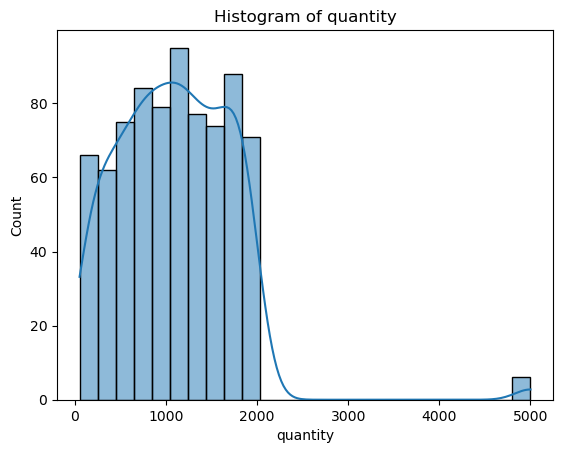

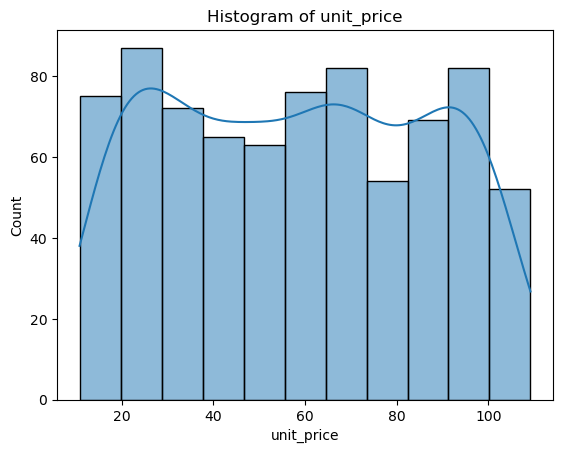

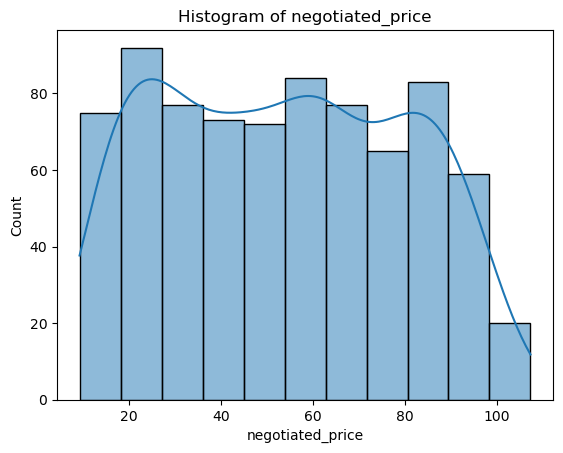

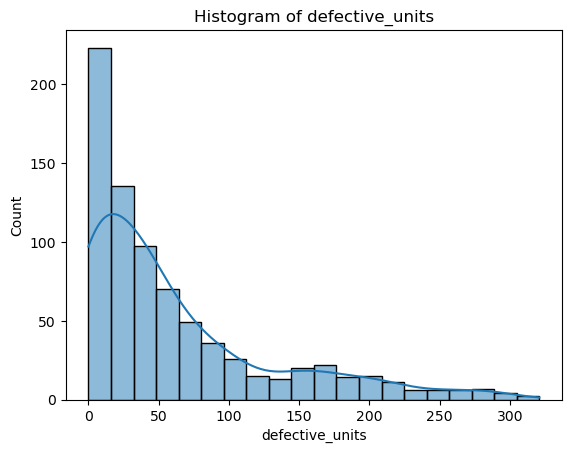

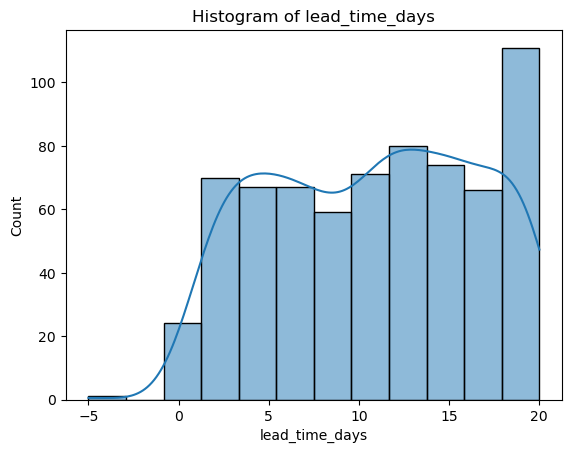

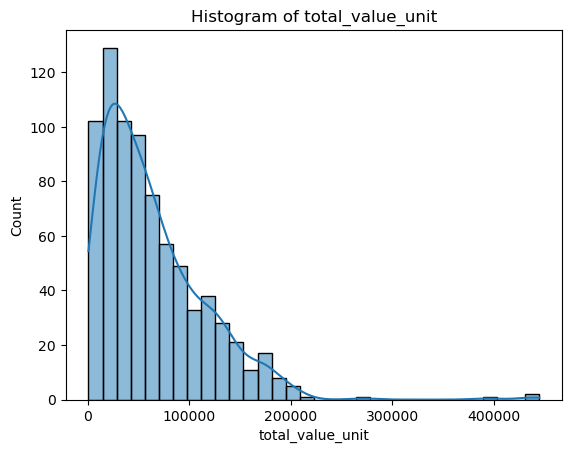

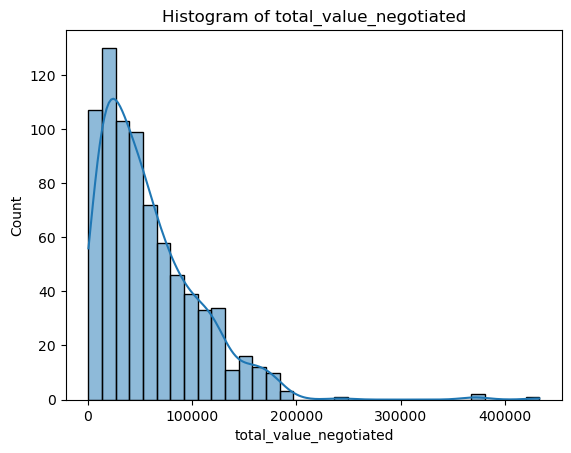

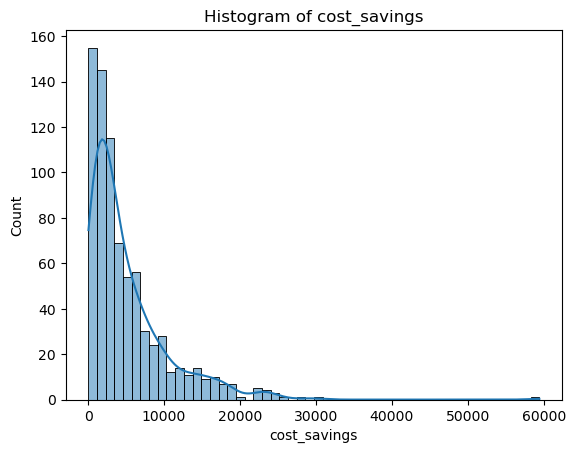

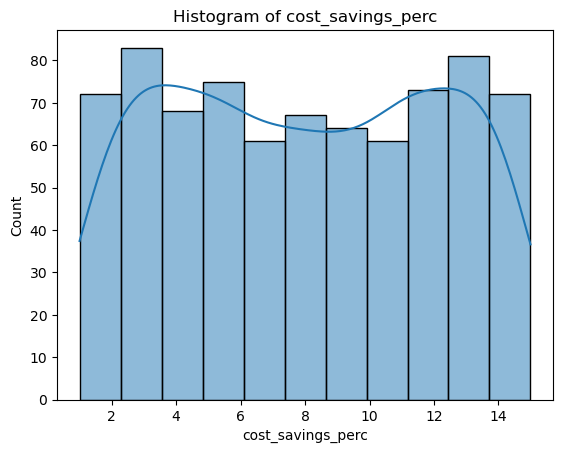

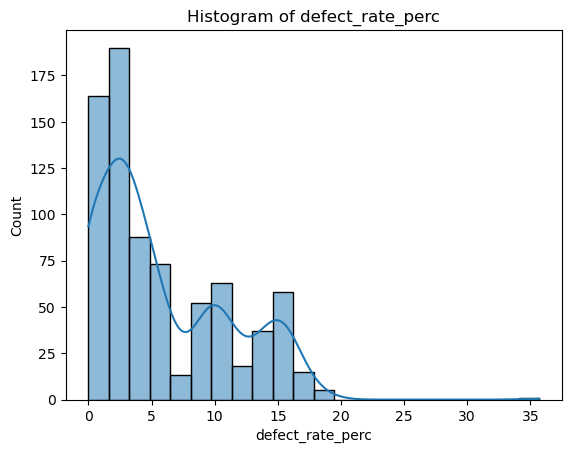

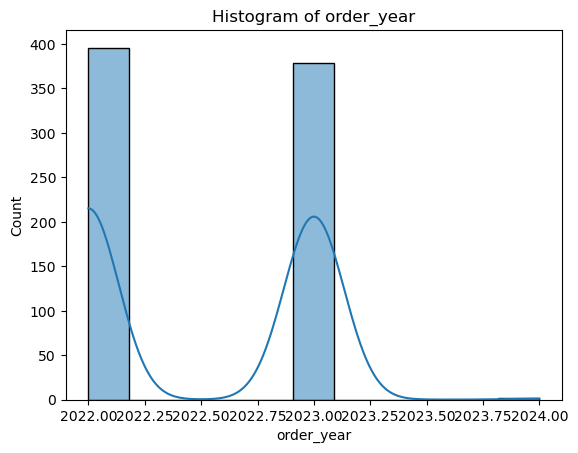

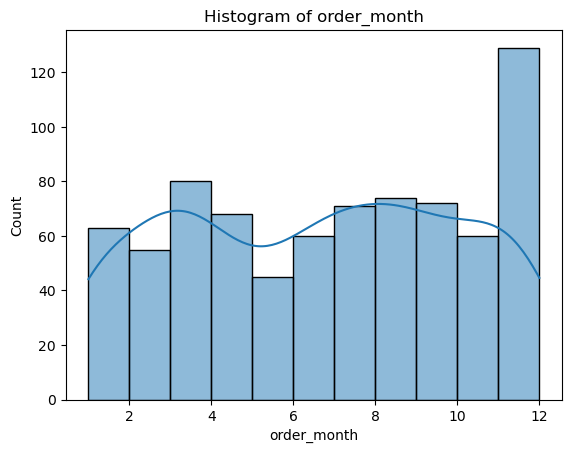

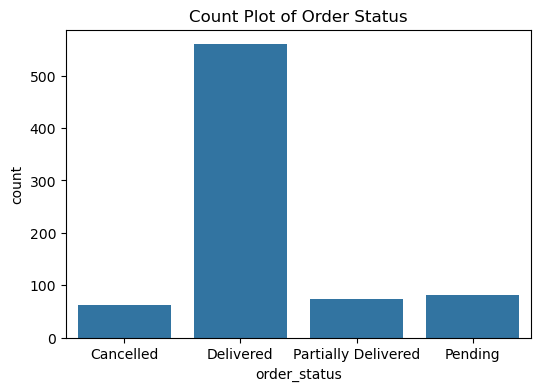

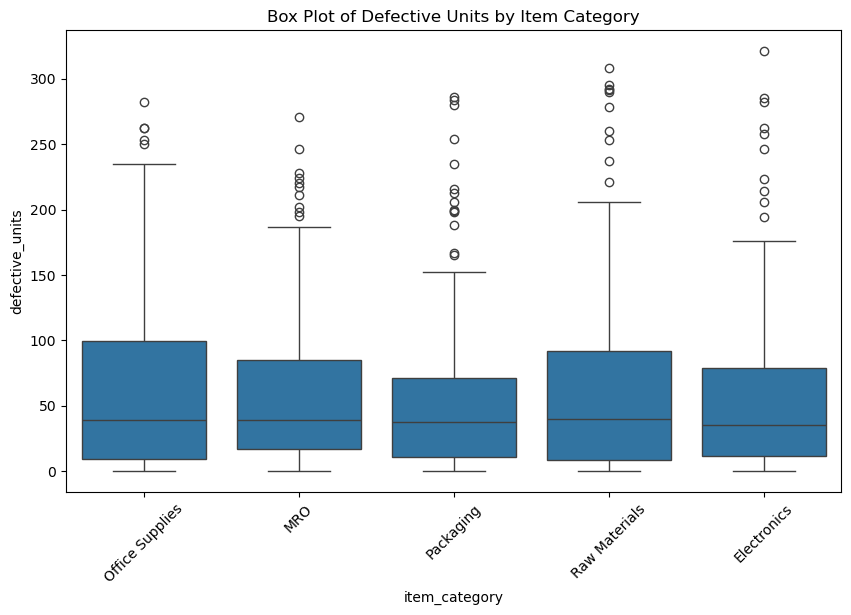

In [143]:
# Extract only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

## Correlation Heatmap (only if 4 or more numeric columns)
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

## Pair Plot
#sns.pairplot(numeric_df)
#plt.show()

## Histograms for numeric features
numeric_features = numeric_df.columns
for feature in numeric_features:
    plt.figure()
    sns.histplot(numeric_df[feature], kde=True)
    plt.title(f'Histogram of {feature}')
    plt.show()

## Pie Chart / Count Plot for Order Status
plt.figure(figsize=(6,4))
sns.countplot(x=df['order_status'])
plt.title('Count Plot of Order Status')
plt.show()

## Box Plot for Defective Units by Item Category (Grouped Barplot style using sns.barplot)
plt.figure(figsize=(10,6))
sns.boxplot(x='item_category', y='defective_units', data=df)
plt.title('Box Plot of Defective Units by Item Category')
plt.xticks(rotation=45)
plt.show()

#### Predictive Modeling

In [144]:
# Data processing & modeling
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_curve, RocCurveDisplay

In [145]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

Balanced class counts:
 delivery_occurred
True     690
False    690
Name: count, dtype: int64

Target mapping: {False: 0, True: 1}

Categorical Features: ['supplier', 'item_category', 'compliance']
Numerical  Features: ['quantity', 'unit_price', 'negotiated_price', 'order_year', 'order_month']

Train:  (1035, 8), (1035,)
Test :  (345, 8), (345,)

--- Logistic Regression ---
Accuracy: 0.7014
              precision    recall  f1-score   support

       False       0.70      0.71      0.70       173
        True       0.70      0.69      0.70       172

    accuracy                           0.70       345
   macro avg       0.70      0.70      0.70       345
weighted avg       0.70      0.70      0.70       345



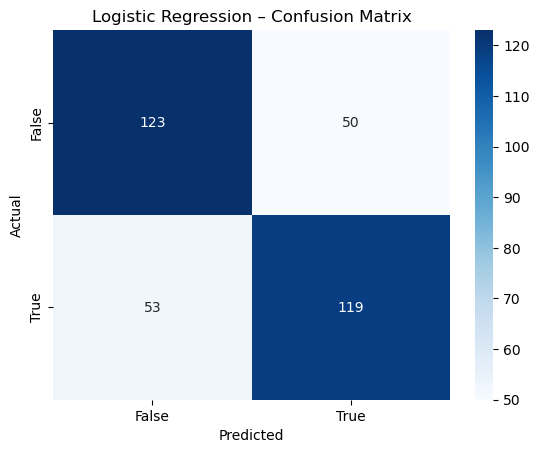


--- Decision Tree ---
Accuracy: 0.7855
              precision    recall  f1-score   support

       False       0.76      0.83      0.80       173
        True       0.81      0.74      0.77       172

    accuracy                           0.79       345
   macro avg       0.79      0.79      0.78       345
weighted avg       0.79      0.79      0.79       345



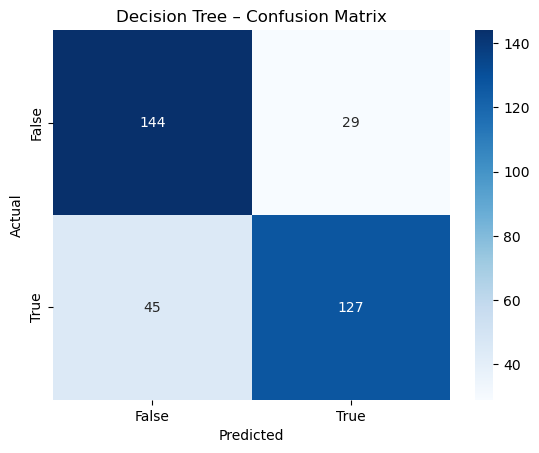


--- Random Forest ---
Accuracy: 0.8667
              precision    recall  f1-score   support

       False       0.88      0.84      0.86       173
        True       0.85      0.89      0.87       172

    accuracy                           0.87       345
   macro avg       0.87      0.87      0.87       345
weighted avg       0.87      0.87      0.87       345



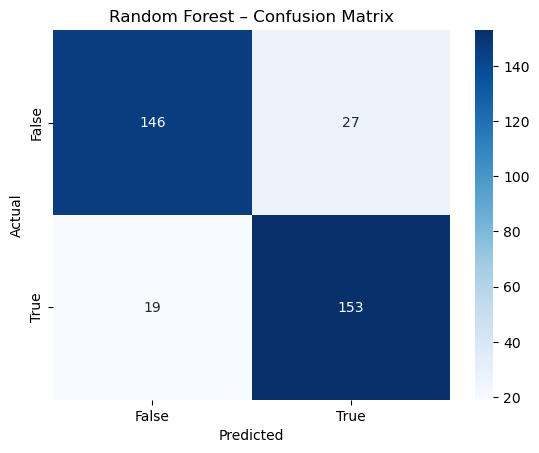


--- Support Vector Machine (SVM) ---
Accuracy: 0.7942
              precision    recall  f1-score   support

       False       0.78      0.82      0.80       173
        True       0.81      0.77      0.79       172

    accuracy                           0.79       345
   macro avg       0.79      0.79      0.79       345
weighted avg       0.79      0.79      0.79       345



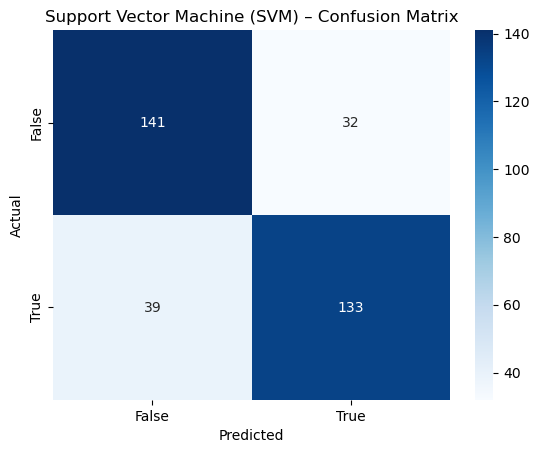


--- AdaBoost ---
Accuracy: 0.8116
              precision    recall  f1-score   support

       False       0.82      0.80      0.81       173
        True       0.81      0.82      0.81       172

    accuracy                           0.81       345
   macro avg       0.81      0.81      0.81       345
weighted avg       0.81      0.81      0.81       345



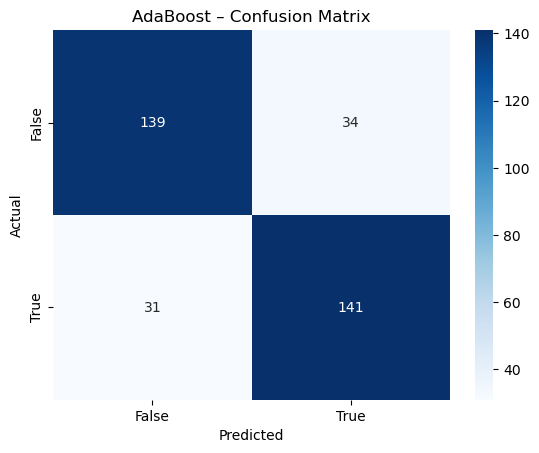


--- K-Nearest Neighbors ---
Accuracy: 0.7652
              precision    recall  f1-score   support

       False       0.71      0.90      0.79       173
        True       0.86      0.63      0.73       172

    accuracy                           0.77       345
   macro avg       0.78      0.76      0.76       345
weighted avg       0.78      0.77      0.76       345



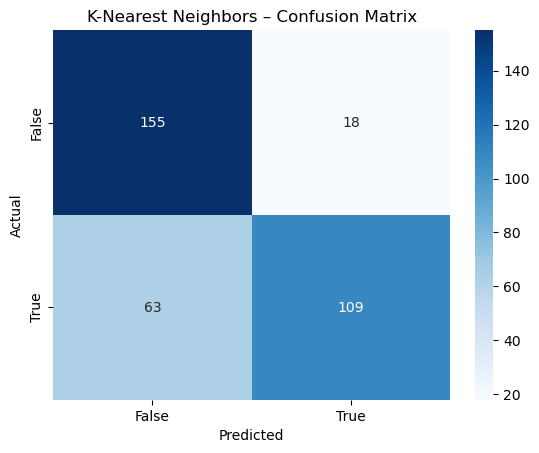


--- Naive Bayes ---
Accuracy: 0.6754
              precision    recall  f1-score   support

       False       0.63      0.84      0.72       173
        True       0.76      0.51      0.61       172

    accuracy                           0.68       345
   macro avg       0.70      0.67      0.67       345
weighted avg       0.70      0.68      0.67       345



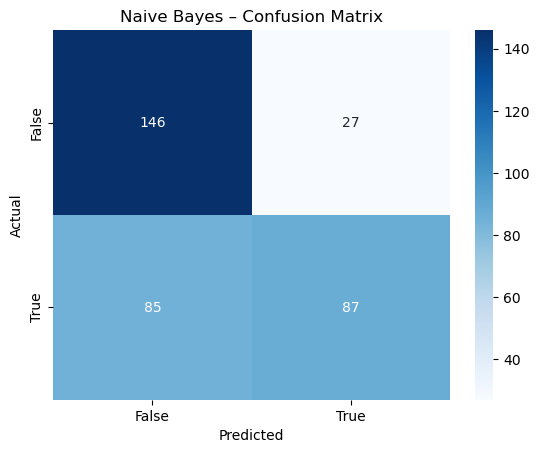


--- Gradient Boosting ---
Accuracy: 0.8870
              precision    recall  f1-score   support

       False       0.92      0.84      0.88       173
        True       0.86      0.93      0.89       172

    accuracy                           0.89       345
   macro avg       0.89      0.89      0.89       345
weighted avg       0.89      0.89      0.89       345



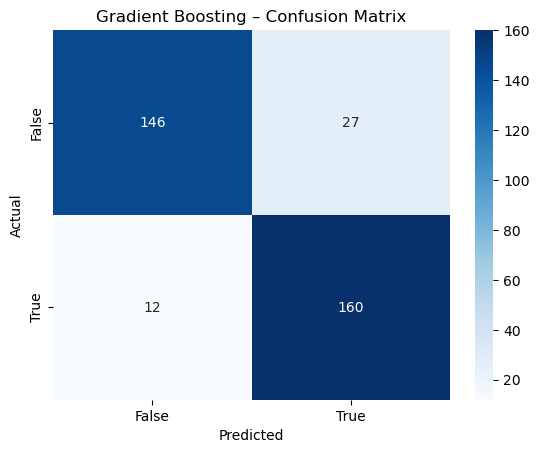


--- Model Accuracy Summary ---
                          Model  Accuracy
7             Gradient Boosting  0.886957
2                 Random Forest  0.866667
4                      AdaBoost  0.811594
3  Support Vector Machine (SVM)  0.794203
1                 Decision Tree  0.785507
5           K-Nearest Neighbors  0.765217
0           Logistic Regression  0.701449
6                   Naive Bayes  0.675362


In [146]:
# -------------------------------------------------------------------------
# 1. Prepare Data for Modeling  (using the SMOTE-balanced DataFrame)
# -------------------------------------------------------------------------
features_for_model = [
    'supplier', 'item_category', 'quantity', 'unit_price', 'negotiated_price',
    'order_year', 'order_month', 'compliance'
]
target_for_model = 'delivery_occurred'

X = df_balanced[features_for_model]
y = df_balanced[target_for_model]          # <-- CHANGED (use balanced labels)

print("Balanced class counts:\n", y.value_counts())

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)            # 1 = Yes, 0 = No
print("\nTarget mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# Identify feature types
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features   = X.select_dtypes(include=np.number).columns.tolist()

print(f"\nCategorical Features: {categorical_features}")
print(f"Numerical  Features: {numerical_features}")

# -------------------------------------------------------------------------
# 2. Pre-processing Pipelines (unchanged)
# -------------------------------------------------------------------------
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# -------------------------------------------------------------------------
# 3. Train / Test Split (now stratified on the balanced y)
# -------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.25,
    random_state=42,
    stratify=y_encoded
)
print(f"\nTrain:  {X_train.shape}, {y_train.shape}")
print(f"Test :  {X_test.shape}, {y_test.shape}")

# -------------------------------------------------------------------------
# 4. Model Dictionary (unchanged)
# -------------------------------------------------------------------------
models_ml = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree":       DecisionTreeClassifier(random_state=42),
    "Random Forest":       RandomForestClassifier(random_state=42),
    "Support Vector Machine (SVM)": SVC(probability=True, random_state=42),
    "AdaBoost":            AdaBoostClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes":         GaussianNB(),
    "Gradient Boosting":   GradientBoostingClassifier(random_state=42)
}

label_names = [str(c) for c in le.classes_]   # ['False', 'True']

# -------------------------------------------------------------------------
# 5. Train & Evaluate (unchanged)
# -------------------------------------------------------------------------
results_ml = {}

for name, model in models_ml.items():
    print(f"\n--- {name} ---")
    pipeline_ml = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier',   model)
    ])
    pipeline_ml.fit(X_train, y_train)

    y_pred = pipeline_ml.predict(X_test)
    try:
        y_prob = pipeline_ml.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_prob = None

    accuracy = accuracy_score(y_test, y_pred)
    report   = classification_report(
        y_test, y_pred,
        target_names=label_names,
        zero_division=0
    )
    cm = confusion_matrix(y_test, y_pred)

    results_ml[name] = {'pipeline': pipeline_ml,
                        'accuracy': accuracy,
                        'report': report,
                        'cm': cm}

    print(f"Accuracy: {accuracy:.4f}")
    print(report)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.title(f'{name} – Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# -------------------------------------------------------------------------
# 6. Accuracy Summary (unchanged)
# -------------------------------------------------------------------------
accuracy_summary_ml = (
    pd.DataFrame({
        'Model':    list(results_ml.keys()),
        'Accuracy': [v['accuracy'] for v in results_ml.values()]
    })
    .sort_values(by='Accuracy', ascending=False)
)
print("\n--- Model Accuracy Summary ---")
print(accuracy_summary_ml)

In [ ]:
# --- Function for Model Training & Evaluation ---
def train_and_evaluate(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\nModel: {model_name}")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()